In [11]:
# Load packages

import os
from typing import Optional
import numpy as np
import pandas as pd

# Deep Learning
import torch
from torch.utils.data import DataLoader

from Nitzan.video_dataset import VideoDataset

import matplotlib.pyplot as plt

BATCH_SIZE = 3

In [12]:
DATA_FOLDER_DICT = {'Victor':'E:\DeepFakeDetection\dfdc_train_all',
                'Nitzan':'D:\dfdc',
                'Netanel':''}
DATA_FOLDER = DATA_FOLDER_DICT['Nitzan']

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

The chosen device: cuda


In [ ]:
part_folders = os.listdir(DATA_FOLDER)
meta_df = pd.DataFrame()

for ii in range(len(part_folders)):
    part_folder = part_folders[ii]
    part_subfolders = os.listdir(os.path.join(DATA_FOLDER, part_folder))
    part_subfolder = part_subfolders[0]
    part_subfolder_path = os.path.join(os.path.join(DATA_FOLDER, part_folder), part_subfolder)
    files = os.listdir(part_subfolder_path)
    json_file = [file for file in files if  file.endswith('json')][0]
    json_file_path = os.path.join(part_subfolder_path, json_file)
    part_df = pd.read_json(json_file_path).T
    part_df['part'] = ii
    part_df['path'] = part_subfolder_path
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])

display(meta_df)

In [14]:
files_num = sum([len(files) for r, d, files in os.walk(DATA_FOLDER)])+1
print(f"Data samples: {files_num}")

Data samples: 119197


KeyError: 'label'

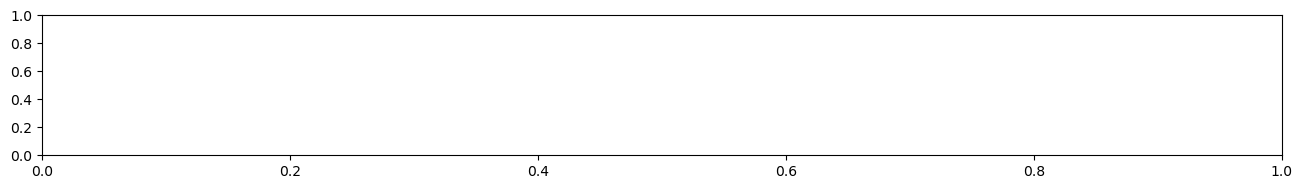

In [15]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

plt.figure(figsize=(16, 4))
ax = plt.subplot(2,1,1)
PlotLabelsHistogram(meta_df['label'],meta_df['label'].unique(),ax)

In [18]:
# Test the VideoDataset
loader = DataLoader(VideoDataset(DATA_FOLDER, 'train'), batch_size=BATCH_SIZE, shuffle=True)

tensor([1, 1, 1])


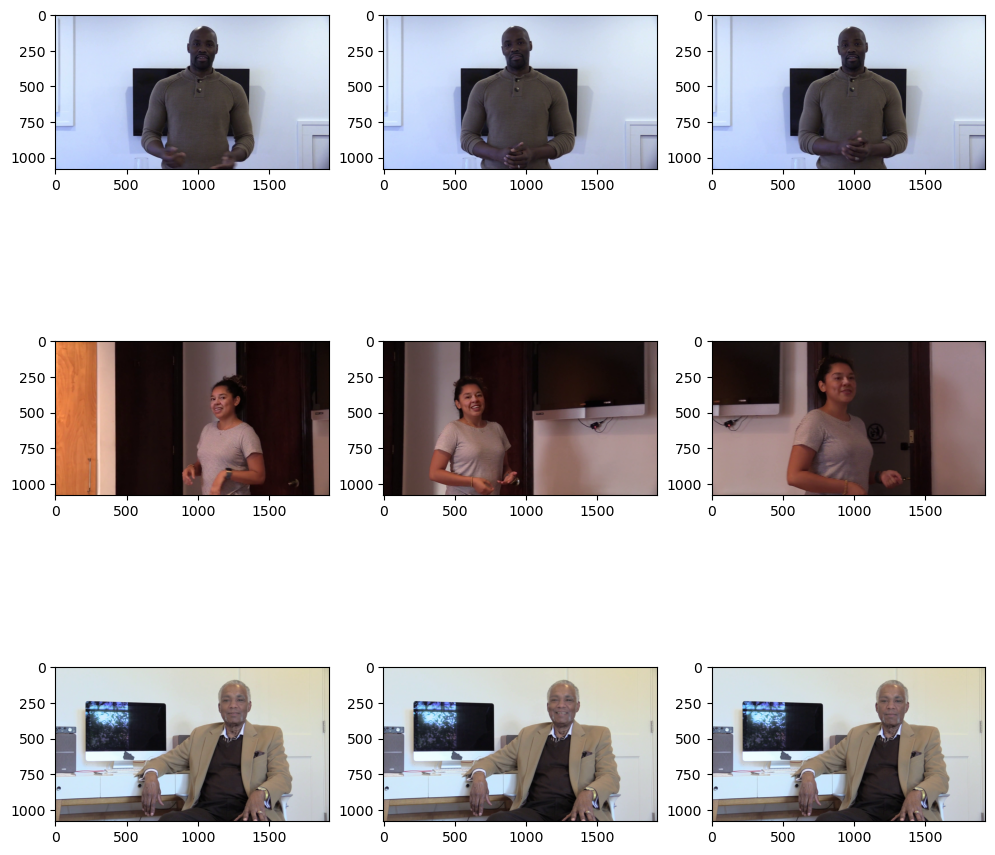

In [19]:
from matplotlib import pyplot as plt

# Get some images & labels from the data loader

data, label = next(iter(loader))

# data dimensions are BxTxCxHxW

fig = plt.figure(figsize=(12, 12))

for i in range(BATCH_SIZE):
  video = data[i]

  fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 1)
  plt.imshow(video[0])
  fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 2)
  plt.imshow(video[100])
  fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 3)
  plt.imshow(video[-1])

print(label)
